<a href="https://colab.research.google.com/github/r-isachenko/2024-DGM-MIPT-YSDA-course/blob/main/seminars/seminar1/PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    # GPU_DEVICE = 2
    # torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# typing
from typing import List, Tuple

## dgm_utils

1. data
2. model
3. train
4. visualize

## Problem setup

In [ ]:
# colab dgm_utils install
REPO_NAME = "dgm_utils"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install .

In [2]:
from dgm_utils import plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

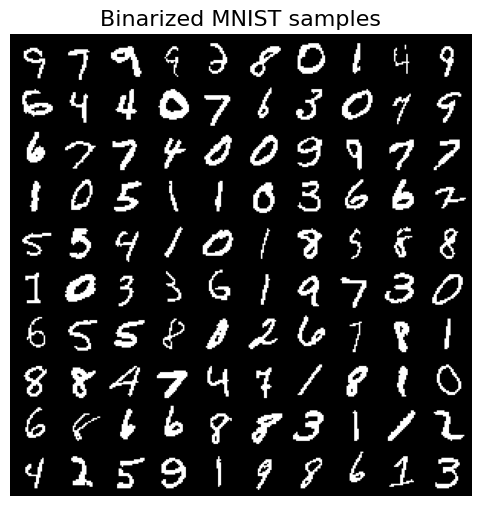

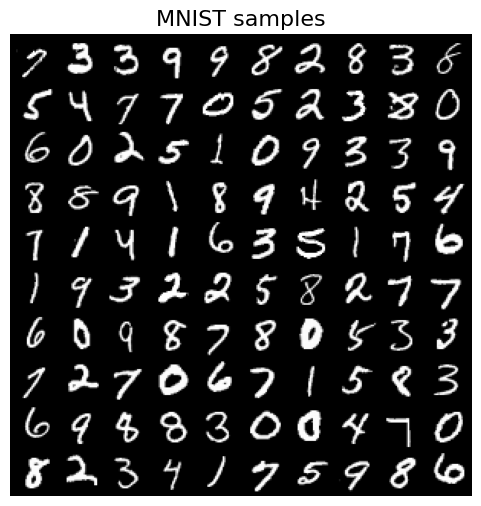

In [4]:
train_data_bin, test_data_bin = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data_bin, "Binarized MNIST samples")
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

## Pixel CNN

The original article: [2016, Oord et. al.](https://arxiv.org/pdf/1601.06759.pdf)

PixelCNN++: [2017, Salimans et. al.](https://arxiv.org/pdf/1701.05517.pdf)

### Autoregressive models for grayscale images

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^{n \times n}$

**Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^{n \times n} \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim p(x_1 | \theta)$

* Sample $\hat{x}_2 \sim p(x_2 | \hat{x}_1 \theta)$

* ...

* Sample $\hat{x}_{n^2} \sim p(x_{n^2} | \hat{\boldsymbol{x}}_{1:n^2-1} , \theta)$

### Ordering

<center>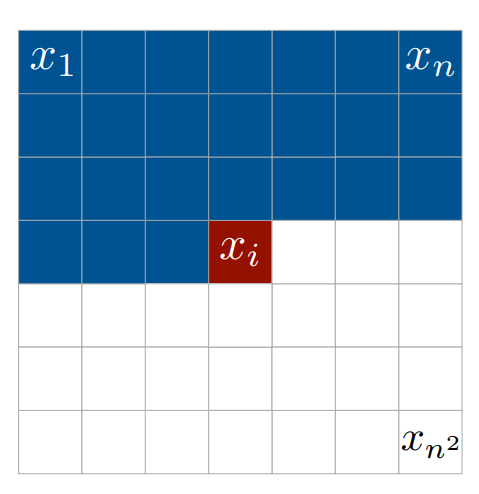</center>

**Question** Will anything change in terms of mathematical formulas for an arbitrary pixel numbering order?

$p(\textbf{x}) = p(x_1)p(x_2|x_1)p(x_3|x_2, x_1)...p(x_N|x_1, ..., x_{N-1})$

## Take a deep breath and work on this step by step

---

## **Masking** to get autoregressive model

### Masked convolutions

* Masked convolution of **type A**:

<center>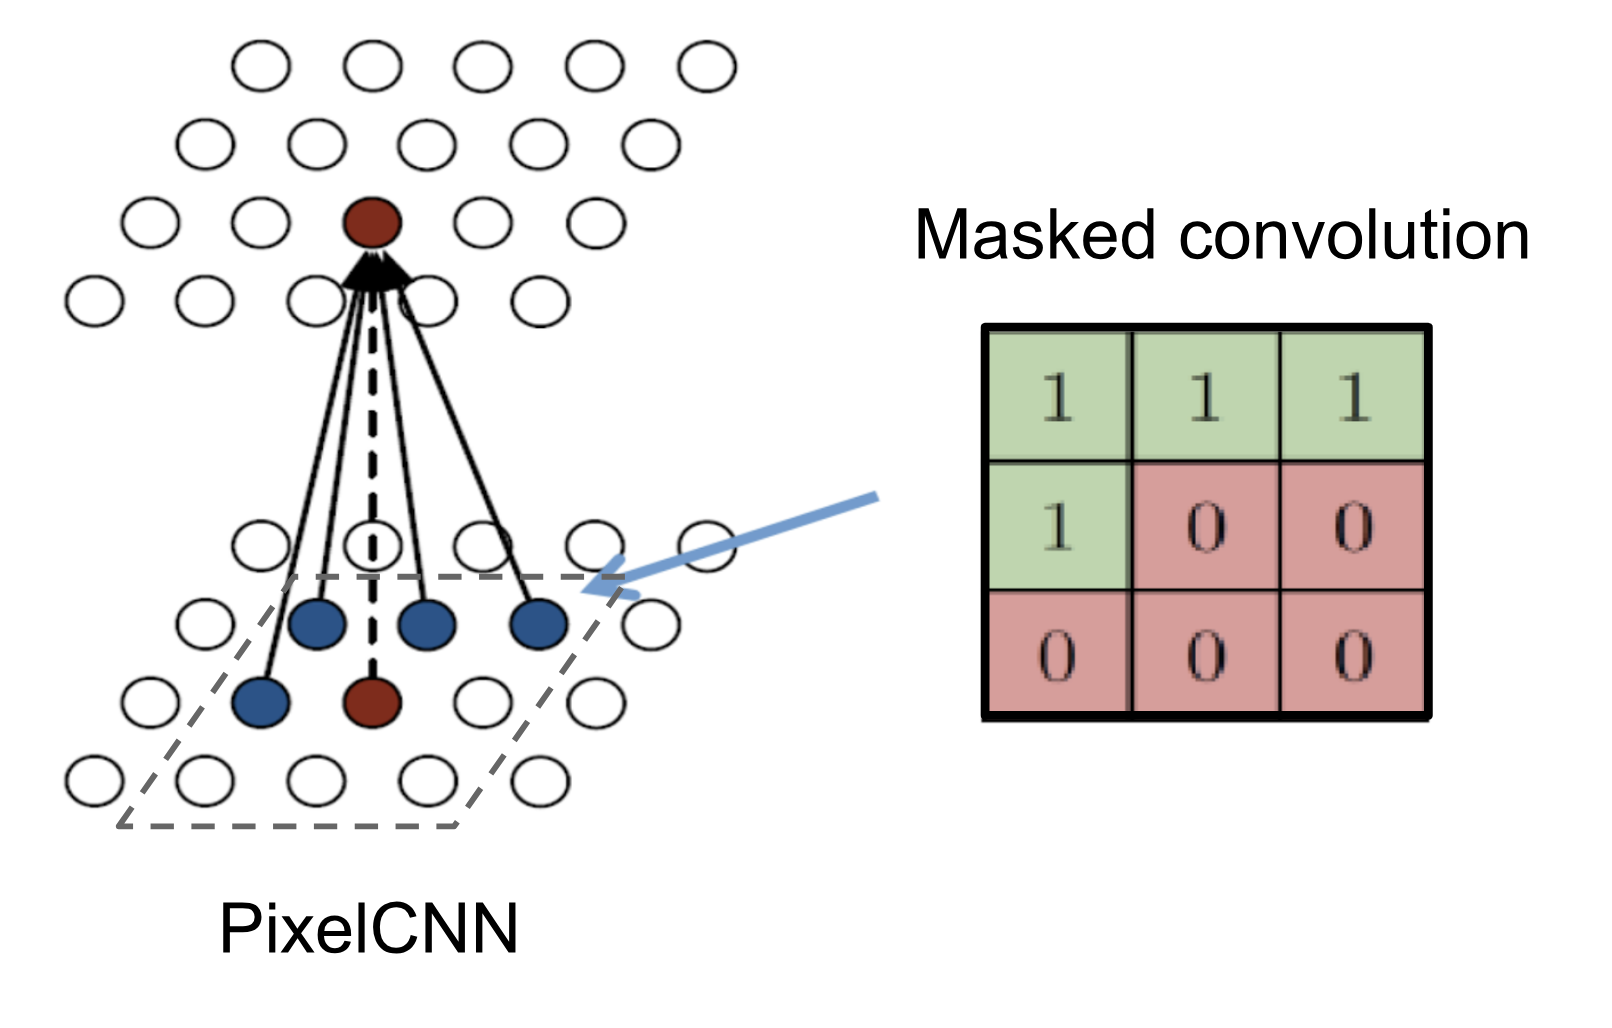</center>

* Masked convolution of **type B** allows self-conditioning

<center>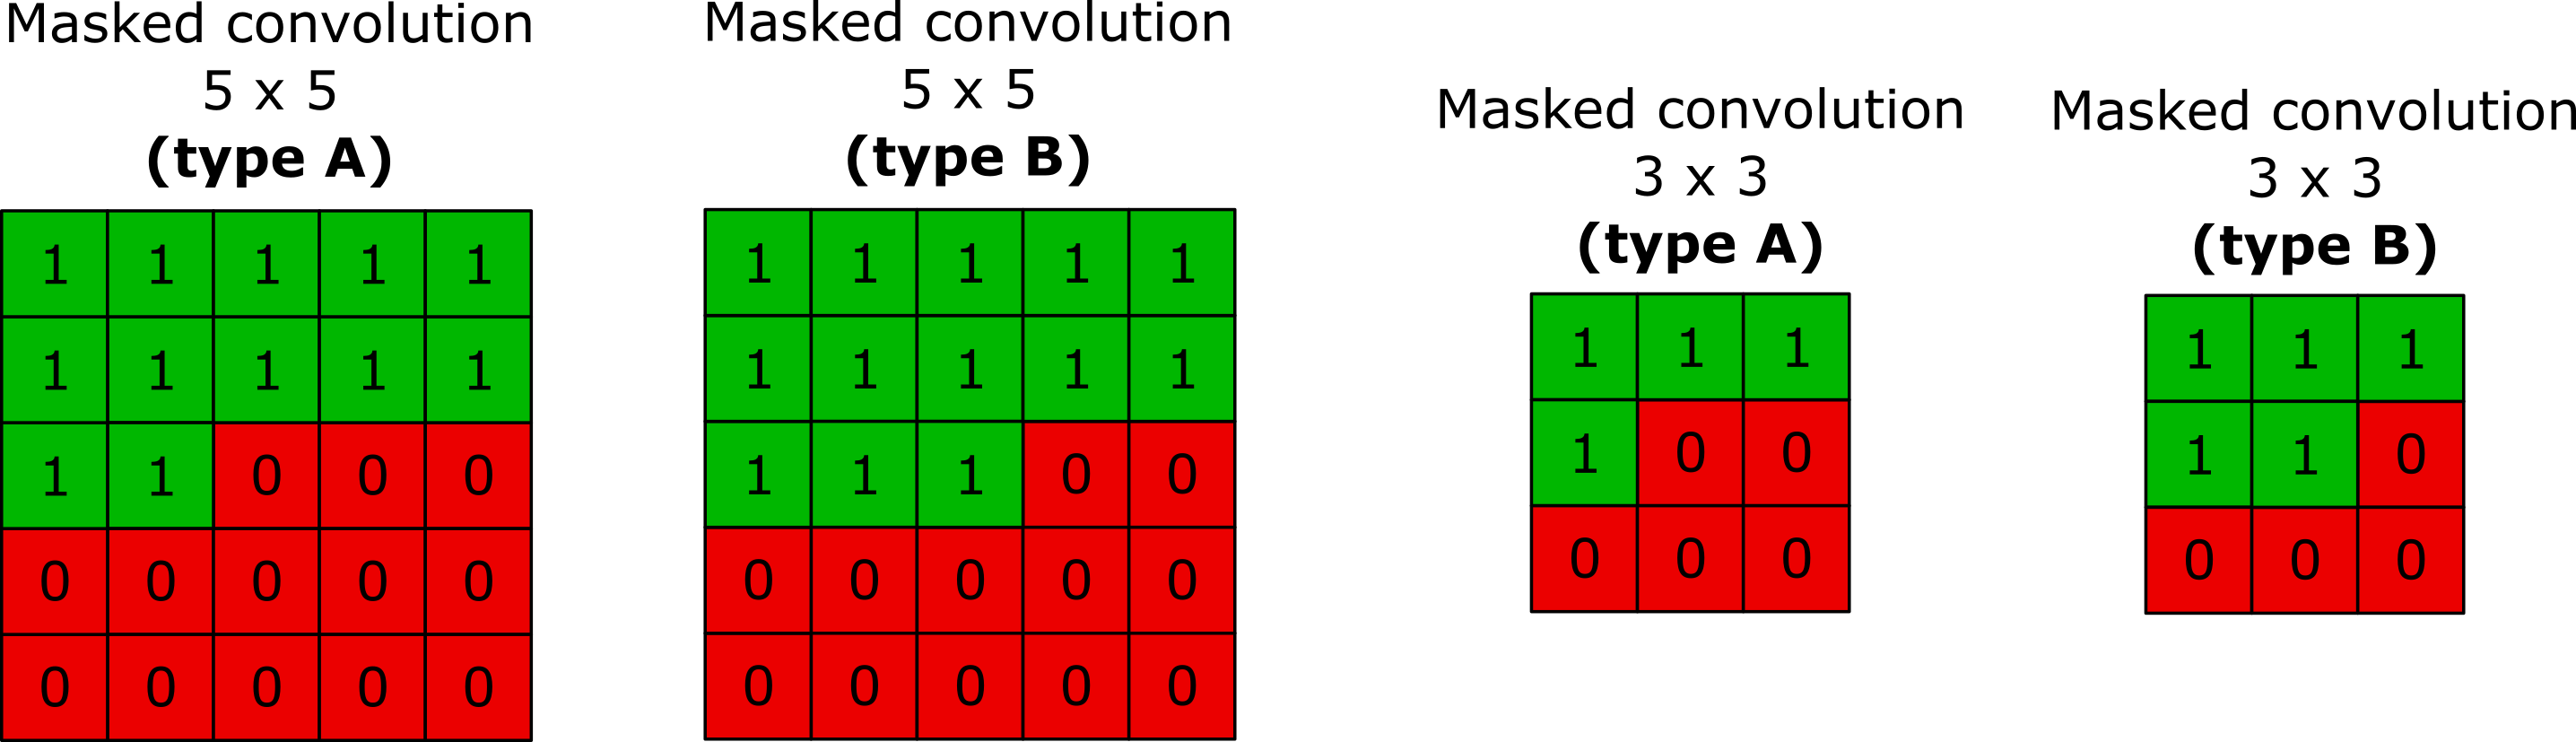</center>

#### Masked convolution implementation

**Question** Why do we need `register_buffer` function? What is the difference between `register_buffer` and `register_parameter`?

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, 
        mask_type: str, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(
        self, 
        input: torch.Tensor
    ) -> torch.Tensor:
        # ====
        # your code
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)
        # ====

    def create_mask(
        self, 
        mask_type: str
    ) -> None:
        # ====
        # your code
        # do not forget about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

## PixelCNN implementation details

**Question 1.**: Where can we apply convolutions of **type B** to preserve autoregressive property?

**Question 2.**: Input tensor shapes?

**Question 3.**: Output tensor shapes?

* **PixelCNN** is fully convolutional NN, which applies masked convolution of **type A** to the input layer and convolutions of **type B** to the hidden layers. 

* It preserves spacial dimensions of a processed tensor

**Question.** How to preserve spatial dimensionality of a processed tensor?

**Helpfull trick** [Layer Normalization](https://arxiv.org/abs/1607.06450) (applied to **channel** dimension) helps to stabilize training process.

**Random fact**
https://arxiv.org/pdf/1803.08494.pdf

<img src="pics/NormLayers.png" width=1200 />

In [6]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

## Generic PixelCNN model

In [7]:
class PixelCNNGeneric(nn.Module):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.spat_shape = spat_shape
        self.out_chan = out_chan

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU) Question: Why?
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be out_chan
        model = [MaskedConv2d("A", 1, hid_chans[0], kernel_size=kernel_size)]

        for in_hid_chan, out_hid_chan in zip(hid_chans[:-1], hid_chans[1:]):
            if use_layer_norm:
                model.append(LayerNorm(in_hid_chan))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", in_hid_chan, out_hid_chan, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=hid_chans[-1], out_channels=out_chan, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)
        # ====

    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5 # Why?
        out = self.net(out)
        # =====
        # your code
        return out.view(batch_size, self.out_chan, 1, *self.spat_shape)
        # =====

### PixelCNN optimization and sampling

**Question 1.** What is the loss function for 

* BinarizedMNIST problem?

* Original (grayscale) MNIST problem?

**Question 2.** How to sample from PixelCNN?

#### PixelCNN based on CrossEntropy. Implementation

In [8]:
import itertools

class CrossEntropyPixelCNNGeneric(PixelCNNGeneric):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        assert out_chan >= 2

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=out_chan, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

        #Note! Will average the output (i.e., returns scaled log likelihood)
        # =======
        # your code
        self.loss_fn = nn.CrossEntropyLoss()
        # ======

    def sample(
        self, n: int
    ) -> np.ndarray:
        # =====
        # your code
        # Note 1: Use torch.multinomial
        # Note 2: Output values should be in [0,1]
        samples = torch.zeros(n, 1, *self.spat_shape).to(DEVICE)
        ordering = itertools.product(range(self.spat_shape[0]), range(self.spat_shape[1]))
        with torch.no_grad():
            for (r, c) in ordering:
                logits = self(samples)[..., r, c] # (bs, out_chan=K, 1)
                probs = F.softmax(logits.squeeze(-1), dim=1) # (bs, out_chan)
                samples[..., r, c] = torch.multinomial(probs, num_samples=1) / float(self.out_chan - 1) # grayscale [0,1]
        # =====
        return samples.cpu().numpy()

####  PixelCNN for binarized MNIST

In [9]:
class BinarizedPixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=2, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        total_loss = self.loss_fn(self(x), x.long())
        # ====
        return {"total_loss": total_loss}

#### PixelCNN for grayscaled MNIST

In [10]:
class GrayScalePixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 128, 256, 512, 256],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape, 
            hid_chans=hid_chans, 
            out_chan=256, 
            kernel_size=kernel_size, 
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # Note: x in [0, 1]
        total_loss = self.loss_fn(self(x), (x * 255.).long())
        # ====
        return {"total_loss": total_loss}

### Training PixelCNN for Binarize MNIST

In [ ]:
from dgm_utils import train_model

In [12]:
# ====
# set your params
EPOCHS = 10  # > 5
BATCH_SIZE = 512  # any adequate value
LR = 1e-3  # < 1e-2
N_LAYERS = 5  # < 10
N_FILTERS = 128  # < 128
USE_LAYER_NORM = True
# ====

model = BinarizedPixelCNN(
    spat_shape=(28, 28),
    hid_chans = [N_FILTERS,] * N_LAYERS,
    kernel_size=5,
    use_layer_norm=USE_LAYER_NORM,
).to(DEVICE)

train_loader = Tdata.DataLoader(train_data_bin, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Tdata.DataLoader(test_data_bin, batch_size=BATCH_SIZE)

optimizer = Adam(model.parameters(), lr=LR)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=None,  # No scheduler for a constant learning rate
    device=DEVICE,
    loss_key="total_loss",  # Use the default loss key or specify as needed
    n_samples=100,  # Set number of samples for visualization
    visualize_samples=True  # Set to False if you don't want visualization
)

  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt



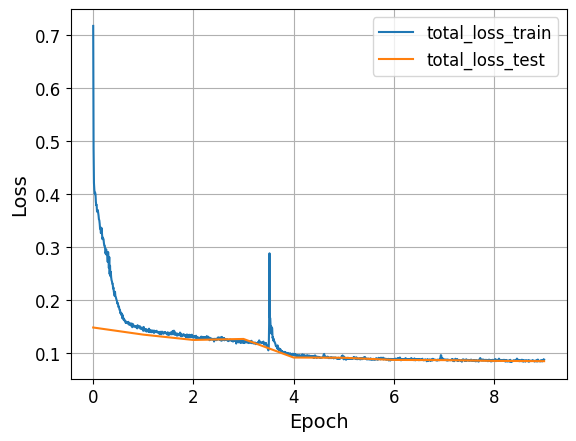

In [19]:
plot_training_curves(train_losses, test_losses)

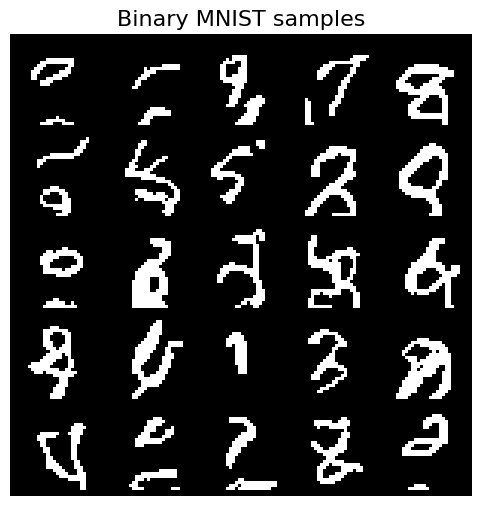

In [20]:
samples = model.sample(25)
show_samples(samples, title="Binary MNIST samples", nrow=5)

#### Training PixelCNN for grayscaled MNIST

In [ ]:
# ====
# set your params
EPOCHS = 10  # > 5
BATCH_SIZE = 128  # any adequate value
LR = 5e-3  # < 1e-2
HIDDEN_CHANNELS = [64, 128, 256, 256, 256]
USE_LAYER_NORM = True
# ====

model = GrayScalePixelCNN(
    spat_shape=(28, 28),
    hid_chans = HIDDEN_CHANNELS,
    kernel_size=5,
    use_layer_norm=USE_LAYER_NORM,
).to(DEVICE)

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Tdata.DataLoader(test_data, batch_size=BATCH_SIZE)

optimizer = Adam(model.parameters(), lr=LR)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=None,  # No scheduler for a constant learning rate
    device=DEVICE,
    loss_key="total_loss",  # Use the default loss key or specify as needed
    n_samples=100,  # Set number of samples for visualization
    visualize_samples=True  # Set to False if you don't want visualization
)

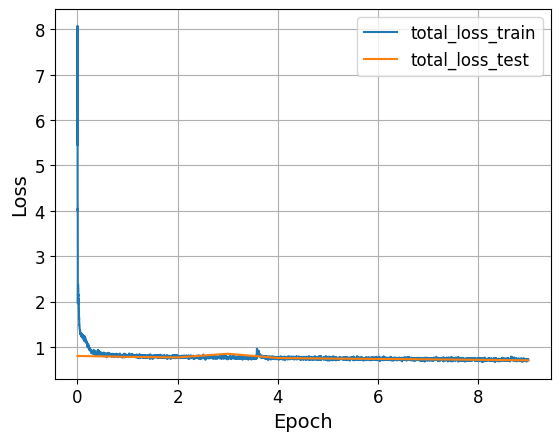

In [23]:
plot_training_curves(train_losses, test_losses)

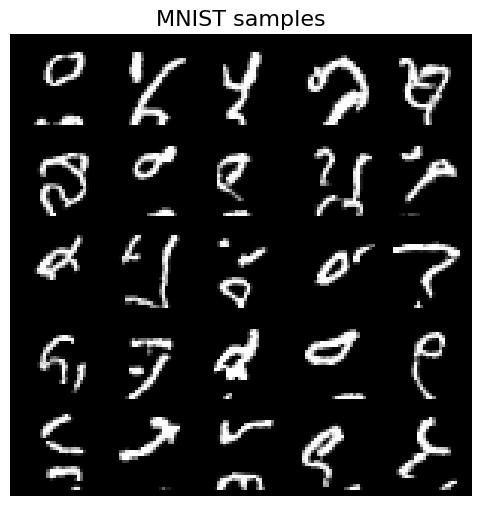

In [24]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)

### PixelCNN for RGB images

$p\left(x_i | \boldsymbol{x}_{1:i-1}, \theta \right) = p\left(x_{i, R} | \boldsymbol{x}_{1:i-1}, \theta \right) p\left(x_{i, G} | x_{i, R}, \boldsymbol{x}_{1:i-1}, \theta\right) p\left(x_{i, B} | x_{i, R}, x_{i, G}, \boldsymbol{x}_{1:i-1}, \theta\right)$

<center>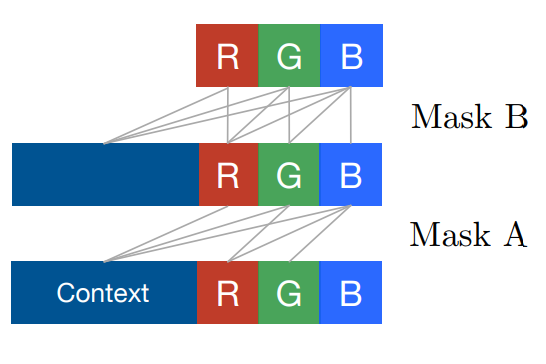</center>

**Question 1.** Input and output tensor shapes? Loss function?

**Question 2.** How to preserve `RGB` structure through the convolutions? How do convolutions look like?

## Futher steps

**Question.** Can PixelCNN predict something except probabilities of pixel's categorical distribution?

Consider more general classes of distributions ($p(x_j | \boldsymbol{x}_{1:j-1} , \theta) \sim \text{Mixture of Gaussians}$ or $\text{Mixture of Logistics}$).  

For example, `PixelCNN++` [link](https://arxiv.org/pdf/1701.05517.pdf) utilizes mixture of logistics.

## Recap

1. **Input:** image `(batch_size, n_channels , H, W)`\
**Output**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^{n \times n} \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$  `(batch_size, K_classes, n_channels, H, W)`
2. **Inference**: input image $x_{i:1}$ - probability distribution $p(x_{i+1}|x_{i:1}, \theta)$ - sampling - new image $x_{i+1:1}$
3. **Trainig** using CrossEntropyLoss to maximize Likelihood
4. **Masking** to get autoregressive model